<img src="https://gist.githubusercontent.com/nesnoj/6ee605cd3494fa6e3e848385c4afbe19/raw/a883b1bdc69c0c5bbb0b00ba92f43033aa86ec64/dingo_model.png" alt="DINGO Model" width="800"  align="center">

In [1]:
import warnings

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
%%capture

from ding0.core import NetworkDing0
from ding0.tools.logger import setup_logger
from ding0.tools.results import save_nd_to_pickle
from ding0.tools.plots import plot_mv_topology
from egoio.tools import db
from sqlalchemy.orm import sessionmaker
import oedialect

from ding0.tools import results # to load pickl file


# create new network
nd = NetworkDing0(name='network')


# set ID of MV grid district
mv_grid_districts = [40] # fn

In [3]:
import osmnx as ox

import networkx as nx 

import pandas as pd
from sqlalchemy import func              
from geoalchemy2.shape import to_shape 


from shapely.geometry import Point, Polygon, LineString



import folium

In [4]:
from config.config_lv_grids_osm import get_config_osm
from config.db_conn_local import create_session_osm 

from grid.lv_grid.routing import build_graph_from_ways, \
get_location_substation_at_pi, subdivide_graph_edges, \
get_mvlv_subst_loc_list, get_cluster_graph_and_nodes, \
add_mv_load_station_to_mvlv_subst_list

from grid.lv_grid.parameterization import parameterize_by_load_profiles
#from grid.lv_grid.clustering import 

from grid.lv_grid.geo import get_Point_from_x_y, get_points_in_load_area, \
get_convex_hull_from_points

#### SET DING0 SETTINGS

In [5]:
# TODO set in config file
ding0_default=False
retain_all=False #  weil sonst graphen außerhalb des polys unverbunden zum graphen beibehalten werden

In [6]:
engine = db.connection(section='oedb_dialect', readonly=True)
session = sessionmaker(bind=engine)()

In [7]:
%%time

print('ding0_default', ding0_default)
if ding0_default:
    
    lv_stations, lv_grid_districts = nd.import_mv_grid_districts(session, mv_grid_districts_no=mv_grid_districts)

else:
    id_db, row, simp_graph, geo_load_area, buildings_w_loads_df, street_loads = nd.import_mv_grid_districts(
        session, ding0_default, mv_grid_districts_no=mv_grid_districts)

ding0_default False
Begin topologically simplifying the graph...
Simplified graph: 162 to 108 nodes, 328 to 220 edges
Wall time: 4.14 s


### clustering

In [8]:
from grid.lv_grid.clustering import get_cluster_numbers, apply_AgglomerativeClustering

In [9]:
n_cluster = get_cluster_numbers(buildings_w_loads_df)
#todo reset n_cluster
n_cluster = 4
labels = apply_AgglomerativeClustering(simp_graph, n_cluster)

In [10]:
cluster_graph, nodes_w_labels = get_cluster_graph_and_nodes(simp_graph, labels)
mvlv_subst_list = get_mvlv_subst_loc_list(cluster_graph, nodes_w_labels, street_loads, labels, n_cluster)

In [11]:
# get loadds on mv level
#mv_lv_level_threshold = get_config_osm('mv_lv_threshold_capacity')
# TODO weg mit den 40 wg testing
mv_lv_level_threshold = 40

loads_mv_df = buildings_w_loads_df.loc[buildings_w_loads_df.capacity >= mv_lv_level_threshold]

#assign cluster id to loads on mv level
mv_cluster_ids = list(range(n_cluster, n_cluster + len(loads_mv_df)))
loads_mv_df['cluster'] = mv_cluster_ids


# map cluster to buildings of lv level
buildings_w_loads_df = buildings_w_loads_df[~buildings_w_loads_df.index.isin(loads_mv_df.index.tolist())]
buildings_w_loads_df['cluster'] = buildings_w_loads_df.nn.map(nodes_w_labels.cluster)


# concat lv and mv level after assignment of cluster ids
buildings_w_loads_df = pd.concat([buildings_w_loads_df, loads_mv_df])


In [12]:
mvlv_subst_list = add_mv_load_station_to_mvlv_subst_list(loads_mv_df, mvlv_subst_list, nodes_w_labels)

In [13]:
mvlv_subst_list

[{'x': 4282465.613186001,
  'y': 2732307.0927902046,
  'node_type': 'non_synthetic',
  'lon': 9.486881299999999,
  'lat': 47.70317630000739,
  'cluster': 0,
  'osmid': 329334526,
  'load_level': 'lv'},
 {'x': 4282038.495855372,
  'y': 2732459.481623211,
  'node_type': 'non_synthetic',
  'lon': 9.481180199999999,
  'lat': 47.70452090000708,
  'cluster': 1,
  'osmid': 331517321,
  'load_level': 'lv'},
 {'x': 4282110.657747543,
  'y': 2732248.5396371987,
  'node_type': 'non_synthetic',
  'lon': 9.4821602,
  'lat': 47.70262710000751,
  'cluster': 2,
  'osmid': 3071953083,
  'load_level': 'lv'},
 {'x': 4282171.9559385115,
  'y': 2732383.5311303716,
  'node_type': 'non_synthetic',
  'lon': 9.482964199999998,
  'lat': 47.703845800007244,
  'cluster': 3,
  'osmid': 443336608,
  'load_level': 'lv'},
 {'x': nan,
  'y': nan,
  'node_type': 'non_synthetic',
  'lon': 9.483255199999999,
  'lat': 47.70450509625661,
  'cluster': 4,
  'osmid': 443338172,
  'load_level': 'mv'}]

In [14]:
cluster_graph_proj = ox.projection.project_graph(cluster_graph, to_crs='epsg:4326')


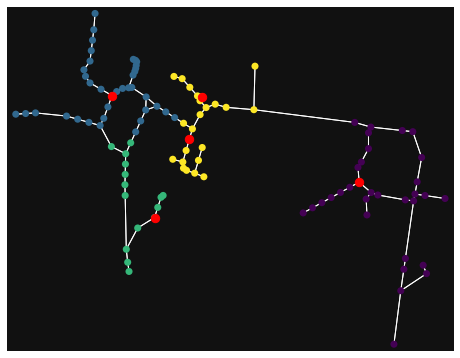

In [15]:
nc = ox.plot.get_node_colors_by_attr(cluster_graph_proj, attr='cluster')
fig, ax = ox.plot_graph(cluster_graph_proj, node_color=nc, node_size=50, edge_color='w', edge_linewidth=1, show=False, close=False)

for mvlv_subst_loc in mvlv_subst_list:
    
    ax.scatter(mvlv_subst_loc['lon'],mvlv_subst_loc['lat'],s=70,c='red')



In [16]:
buildings_w_loads_df.cluster.value_counts()

1    57
0    37
3    36
2    23
4     1
Name: cluster, dtype: int64

In [21]:
row

zensus_sum                                                               261.0
zensus_cnt                                                                18.0
ioer_sum                                                                  None
ioer_cnt                                                                  None
area                                                                 21.629852
sector_area_residential                                              11.895053
sector_area_retail                                                         NaN
sector_area_industrial                                                     NaN
sector_area_agricultural                                                   NaN
sector_share_residential                                              0.549937
sector_share_retail                                                        NaN
sector_share_industrial                                                    NaN
sector_share_agricultural                           

In [20]:
id_db

5588

In [112]:
from shapely.geometry import MultiPoint, Point, shape
from grid.lv_grid.geo import get_points_in_load_area, get_convex_hull_from_points

In [128]:
%%time

ch_polys = []

for cluster_i in range(len(mvlv_subst_list)):

    # get convex hull per cluster
    cluster_geo_list = buildings_w_loads_df.loc[buildings_w_loads_df.cluster==cluster_i].geometry.tolist()

    points = get_points_in_load_area(cluster_geo_list)

    polygon = get_convex_hull_from_points(points)
    
    ch_polys.append(polygon)
    
    
for geo in mv_load_substation_geo_list:
    
    points = get_points_in_load_area([geo])

    polygon = get_convex_hull_from_points(points)
    
    ch_polys.append(polygon)

Wall time: 69 ms


In [104]:
# init empty stations_df
lv_stations = pd.DataFrame(columns=['la_id', 'geom'])
lv_stations.index.name = 'mvlv_subst_id'

In [124]:
# add stations for cluster load centers
last_row_ix = len(lv_stations)
for mvlv_subst_loc in mvlv_subst_list:
    
    cluster_id = mvlv_subst_loc.get('cluster')
    lv_stations.loc[last_row_ix+cluster_id] = [id_db, Point(mvlv_subst_loc.get('lon'),mvlv_subst_loc.get('lat'))]
    
    
    
    
# add stations for buildings on mv level
mv_load_substation_loc_list = buildings_w_loads_df.loc[buildings_w_loads_df.capacity >= mv_lv_level_threshold].nn_coords.tolist()
mv_load_substation_geo_list = buildings_w_loads_df.loc[buildings_w_loads_df.capacity >= mv_lv_level_threshold].geometry.tolist()


for mv_load_substation_loc in mv_load_substation_loc_list:
    
    lv_stations.loc[len(lv_stations)] = [id_db, mv_load_substation_loc]


In [125]:
lv_stations

,la_id,geom
mvlv_subst_id,,
0,5588,POINT (9.486881299999999 47.70317630000739)
1,5588,POINT (9.481180199999999 47.70452090000708)
2,5588,POINT (9.482160199999999 47.70262710000751)
3,5588,POINT (9.482964199999998 47.70384580000724)
4,5588,POINT (9.483255199999999 47.70450509625661)
5,5588,POINT (9.486881299999999 47.70317630000739)
6,5588,POINT (9.481180199999999 47.70452090000708)
7,5588,POINT (9.482160199999999 47.70262710000751)
8,5588,POINT (9.482964199999998 47.70384580000724)


In [11]:
lv_stations.head(2)

,la_id,geom
mvlv_subst_id,,
2873,2520,POINT(9.49063792246541 47.7452397283099)
3053,2728,POINT(9.49342672911522 47.7327193529698)


In [129]:
nodes, edges = ox.graph_to_gdfs(cluster_graph)

m = folium.Map([polygon.centroid.y, polygon.centroid.x], zoom_start=16)
for polygon in ch_polys:
    folium.GeoJson(polygon).add_to(m)
folium.GeoJson(edges).add_to(m)
m


In [ ]:
# init empty stations_df
lv_grid_districts = pd.DataFrame(columns=['la_id', 'geom'])
lv_grid_districts.index.name = 'mvlv_subst_id'

In [12]:
lv_grid_districts.head(2)

,la_id,population,peak_load_residential,peak_load_retail,peak_load_industrial,peak_load_agricultural,peak_load,geom,sector_count_residential,sector_count_retail,sector_count_industrial,sector_count_agricultural,sector_consumption_residential,sector_consumption_retail,sector_consumption_industrial,sector_consumption_agricultural
mvlv_subst_id,,,,,,,,,,,,,,,,
419093,5372,10.0,3.493570,0.0,0.0,99.525989,103.019559,MULTIPOLYGON(((9.44476423426424 47.69930354485...,0.0,0.0,0.0,2.0,16346.482102,0.0,0.0,414070.515734
420154,4830,3.0,1.048071,0.0,0.0,0.000000,1.048071,MULTIPOLYGON(((9.49954883830014 47.68339565373...,1.0,0.0,0.0,0.0,4903.944631,0.0,0.0,0.000000


In [22]:
# update load areal peak loads in the end 
# due to residentials at feeder needs to be updated
buildings_w_loads_df.capacity.sum()

250.2653091931388

In [ ]:
# additionally for object
# lv_grid as lv_grid-Obect

# df
la_id
population
peak_load_residential
peak_load_retail
peak_load_industrial
peak_load_agricultural
peak_load
geom
sector_count_residential
sector_count_retail
sector_count_industrial
sector_count_agricultural
sector_consumption_residential
sector_consumption_retail
sector_consumption_industrial
sector_consumption_agricultural

In [15]:
# district e.g.
'id_db': 4563,
'geo_data': <shapely.geometry.multipolygon.MultiPolygon at 0x17ffc430160>,
'lv_load_area': lv_load_area_4544,
'lv_grid': lv_grid_4563,
'population': 80,
'peak_load_residential': 27.9485612387548,
'peak_load_retail': 0.0,
'peak_load_industrial': 0.0,
'peak_load_agricultural': 0.0,
'peak_load': 27.9485612387548,
'sector_count_residential': 1,
'sector_count_retail': 0,
'sector_count_industrial': 0,
'sector_count_agricultural': 0,
'sector_consumption_residential': 130771.856816184,
'sector_consumption_retail': 0.0,
'sector_consumption_industrial': 0.0,
'sector_consumption_agricultural': 0.0

,category,area,geometry,raccordement_building,name,number_households,n_amenities_inside,osm_id_building,geometry_amenity,x,y,capacity,nn,nn_dist,nn_coords
443340114,restaurant,732.547,"POLYGON ((9.483392699999998 47.70459640000707,...",POINT (9.48352605 47.70469195000704),Sportplatz-Restaurant,1.0,1.0,301431136.0,0101000020e6100000c3d3861e8cf72240da9a83ea30da...,9.483526,47.704692,67.035376,443338172,29.025206,POINT (9.483255199999999 47.70450509625661)


In [ ]:
# todo check if truncate creates subgrpahs
# if len(subgraphs) > 1:
    # there are unconnected subgraphs
    # then for each subgraph
        # cluserting
        # for each cluster
            # build lv_grid_district

### Clustering

In [27]:
n_clusters = get_n_cluster(buildings_w_loads_df)
if n_clusters < len(fn_fallenbrunnen_la._lv_grid_districts):
    n_clusters = len(fn_fallenbrunnen_la._lv_grid_districts)
buildings_w_loads_df = cluster_k_means(buildings_w_loads_df, n_clusters)

In [29]:
n_clusters

3

### Update and add _districts

In [30]:
for i in range(n_clusters):
    
    print(len(buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==i)]))


99
85
79


In [28]:
buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)]

,category,capacity,area,number_households,x,y,geometry,raccordement,nn,nn_dist,Cluster
osm_id,,,,,,,,,,,
8598838279,ice_cream,20.966863,229.121,0.645161,9.437183,47.674769,"POLYGON ((9.437094099999998 47.67477800001394,...",POINT (9.437183076702567 47.67476938145773),475940044,19.021132,0
144020300,public_building,244.695822,2113.09,0.8125,9.438239,47.675506,"POLYGON ((9.437905999999998 47.67551250001376,...",POINT (9.438238891069723 47.67550616796044),1576023053,34.831012,0
144023114,school,102.108142,1641.61,0.552632,9.438521,47.673818,"POLYGON ((9.438203599999998 47.67375600001416,...",POINT (9.438521488700175 47.67381754064048),68844093,33.677840,0
314909001,residential,1.246721,100,0.72973,9.43711,47.674319,"POLYGON ((9.4370154 47.67431780001401, 9.43711...",POINT (9.437109750000001 47.67431900001404),2080880814,14.638173,0
314909020,house,1.102239,100,0.645161,9.437548,47.674401,"POLYGON ((9.4374646 47.674413400014, 9.4375446...",POINT (9.437548450000001 47.67440130001403),314975344,15.374000,0
...,...,...,...,...,...,...,...,...,...,...,...
314913916,residential,2.904399,100,1.7,9.436301,47.672468,"POLYGON ((9.436173800000001 47.67246730001447,...",POINT (9.436301343479869 47.67246766666069),311379901,30.431139,0
338514542,school,407.558658,6552.39,0.594203,9.438414,47.673881,"POLYGON ((9.437957300000001 47.67387860001414,...",POINT (9.438414351486788 47.67388107322754),68844093,31.901109,0
401560706,residential,1.102239,100,0.645161,9.43769,47.674448,"POLYGON ((9.4376228 47.674467300014, 9.4377058...",POINT (9.437690147469656 47.67444791593603),314975344,27.030240,0


In [16]:
%%time

geometry = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0), 'geometry'].tolist()

points = get_points_in_load_area(geometry)
        
len(points)

Wall time: 9.38 ms


140

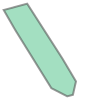

In [17]:
get_convex_hull_from_points(points)

In [24]:
fn_fallenbrunnen_la.lv_load_area_group.__dict__

{'id_db': 20,
 'mv_grid_district': mv_grid_district_40,
 '_lv_load_areas': [lv_load_area_4544,
  lv_load_area_4545,
  lv_load_area_4548,
  MVCableDist_mvgd_40_26],
 'peak_load': 65.35928151751943,
 'branch_length_sum': 0,
 'peak_load_max': 1000.0,
 'branch_length_max': 2000.0,
 'root_node': MVCableDist_mvgd_40_23}

In [28]:
nd._mv_grid_districts[0].__dict__

{'id_db': 40,
 'mv_grid': mv_grid_40,
 '_lv_load_areas': [lv_load_area_2128,
  lv_load_area_2292,
  lv_load_area_2383,
  lv_load_area_2520,
  lv_load_area_2521,
  lv_load_area_2561,
  lv_load_area_2608,
  lv_load_area_2625,
  lv_load_area_2633,
  lv_load_area_2705,
  lv_load_area_2728,
  lv_load_area_2763,
  lv_load_area_2765,
  lv_load_area_2840,
  lv_load_area_2842,
  lv_load_area_3029,
  lv_load_area_3088,
  lv_load_area_3089,
  lv_load_area_3119,
  lv_load_area_3160,
  lv_load_area_3235,
  lv_load_area_3277,
  lv_load_area_3304,
  lv_load_area_3305,
  lv_load_area_3307,
  lv_load_area_3311,
  lv_load_area_3314,
  lv_load_area_3403,
  lv_load_area_3413,
  lv_load_area_3645,
  lv_load_area_3661,
  lv_load_area_3731,
  lv_load_area_3780,
  lv_load_area_3805,
  lv_load_area_3911,
  lv_load_area_3986,
  lv_load_area_3987,
  lv_load_area_3992,
  lv_load_area_4212,
  lv_load_area_4337,
  lv_load_area_4347,
  lv_load_area_4487,
  lv_load_area_4488,
  lv_load_area_4544,
  lv_load_area_4545,

In [17]:
fn_fallenbrunnen_la._lv_grid_districts[0].lv_grid._station.__dict__

{'id_db': 4563,
 'geo_data': <shapely.geometry.point.Point at 0x118800eba90>,
 'grid': lv_grid_4563,
 '_transformers': [Transformer_lv_grid_4563_1],
 'v_level_operation': None,
 'lv_load_area': lv_load_area_4544,
 'voltage_res': [0.9897135909377942, 1.0123145234795161]}

In [17]:
preprocessed_clusters = []   
    

for cluster_id in range(n_clusters):
    
    if cluster_id < len(fn_fallenbrunnen_la._lv_grid_districts):
        
        print('delete or update _lv_grid_districts[', cluster_id, ']')
        
        # GET NEW VALUES FOR DISTRICT        
        # get convex hull of cluster
        points = get_points_in_load_area(buildings_w_loads_df.loc[buildings_w_loads_df['Cluster']==cluster_id])
        district_convex_hull = get_convex_hull_from_points(points)
        
        # get location of substation for cluster
        station_x, station_y = get_location_substation_at_pi(graph, buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)])

        
        # UPDATE VALUES
        # update values of _lv_grid_districts[cluster_id]
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].geo_data  = district_convex_hull
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].poulation = buildings_w_loads_df.loc[buildings_w_loads_df['Cluster']==cluster_id]['number_households'].sum()
        
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].peak_load = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)]['capacity'].sum()
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].peak_load_residential = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==cluster_id) & buildings_w_loads_df['number_households'] > 0]['capacity'].sum()
        
        
        # ADD / RESET DING0 ELEMENTS
        # update position of substation
        fn_fallenbrunnen_la._lv_grid_districts[0].lv_grid._station.geo_data = get_Point_from_x_y(station_x, station_y)
        
        # reset list to add new elements
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].lv_grid._station.transformers.clear()
        
        
        # update trafo and loads
        #fn_fallenbrunnen_la._lv_grid_districts[cluster_id].lv_grid.build_grid()
        
        
    else:
        
        print('add _lv_grid_districts id', cluster_id)
        
        
        
        
        
    break
    

update _lv_grid_districts 0
add _lv_grid_districts id 1
add _lv_grid_districts id 2


In [21]:
fn_fallenbrunnen_la._lv_grid_districts[0].lv_grid._station.__dict__

{'id_db': 4563,
 'geo_data': <shapely.geometry.point.Point at 0x1d50cd257f0>,
 'grid': lv_grid_4563,
 '_transformers': [Transformer_lv_grid_4563_1],
 'v_level_operation': None,
 'lv_load_area': lv_load_area_4544,
 'voltage_res': [0.9897135909377942, 1.0123145234795161]}

In [19]:
#lv_district_of_interest.lv_grid.graph_draw(mode='LV')

In [16]:
lv_district_of_interest.lv_grid.__dict__ # .geo_data.wkt

NameError: name 'lv_district_of_interest' is not defined

In [19]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

In [20]:
X = []    # collect nodes

for node in graph.nodes:

    X.append([graph.nodes[node]['X'], graph.nodes[node]['Y']])
    
    
X = np.array(X)



# clustering

adj_mat_sparse = nx.adjacency_matrix(graph, weight='length')

clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=adj_mat_sparse).fit(X)






# assign cluster labels

i_label = 0

for node in list(graph.nodes):

    graph.nodes[node]['cluster'] = clustering.labels_[i_label]
    
    i_label += 1
    
labels = nx.get_node_attributes(graph, 'cluster') 

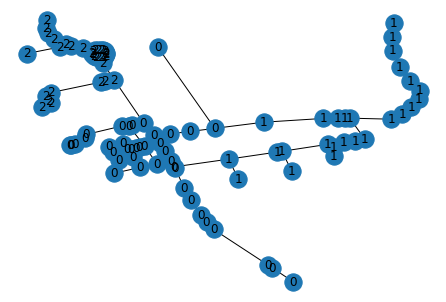

In [23]:
nx.draw(graph, node_coords_dict,labels=labels)

In [24]:
X = []    # collect nodes

for node in graph.nodes:

    X.append([graph.nodes[node]['X'], graph.nodes[node]['Y']])
    
    
X = np.array(X)



# clustering

adj_mat_sparse = nx.to_numpy_matrix(graph, weight='length')

clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=adj_mat_sparse).fit(X)






# assign cluster labels

i_label = 0

for node in list(graph.nodes):

    graph.nodes[node]['cluster'] = clustering.labels_[i_label]
    
    i_label += 1
    
labels = nx.get_node_attributes(graph, 'cluster') 

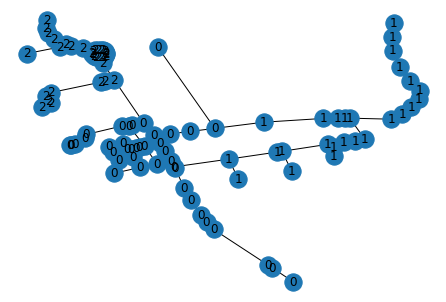

In [25]:
nx.draw(graph, node_coords_dict,labels=labels)